In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import json
from lib.ds2s_OV_xmin import ds2s_OV_xmin
from lib.funcs import *
import itertools

In [2]:
x_min = 0.1  # 車両の長さ: 5.0mで換算

L = 10.0  # レーンの長さ: 470m
n_0 = 5

x_0 = ((5.0+3.0)/5.0) * x_min  # 最小車間距離: 車両の長さ+3mで換算
v_0 = (1000/36)/5.0 * x_min  # 車両の最高速度: 法定速度100km/hで換算
dt = 1.0  # 時間差分1秒
dx = 0.1  # テキトー。基本図がいい感じになるように調整

In [3]:
density_trivial = [K/L for K in range(101)]
flow_trivial = [
	flow_stable(
		density=d,
		x_0=x_0,
		v_0=v_0,
		dt=dt,
		dx=dx,
		xmin=x_min
	) for d in density_trivial
]

In [4]:
ni, nf = 10000, 10100
data = []
for jams in range(1, 10):
	data_ = {}
	for id, K in enumerate(range(101)):
		print("\rjams={} id={:2}".format(jams, id), end="")
		if K < jams:
			continue
		x_init = np.array(
			list(itertools.chain.from_iterable([
				[L/jams * n_jam + x_min * i for i in range((K+n_jam)//jams)]
					for n_jam in range(0, jams)
			])),
			dtype=np.float64
		).flatten()
		# print(x_init)
		model = ds2s_OV_xmin(
			L=L,
			K=K,
			n_0=n_0,
			x_0=x_0,
			v_0=v_0,
			dt=dt,
			dx=dx,
			x_min=x_min,
			x_init=x_init,
			n_max=nf+5,
		)
		model.simulate()
		js = model.get_json()
		js["flow"] = { "{ni} {nf}": model.flow(ni, nf) }
		data_[id] = js
	data.append(data_)

jams=9 id=100

In [5]:
data_ = {}
for id, K in enumerate(range(101)):
	print("\rid={}".format(id), end="")
	x_init = np.array(
		sorted(random.sample([x_min * i for i in range(100)], K))
	)
	model = ds2s_OV_xmin(
		L=L,
		K=K,
		n_0=n_0,
		x_0=x_0,
		v_0=v_0,
		dt=dt,
		dx=dx,
		x_min=x_min,
		x_init=x_init,
		n_max=nf+5,
	)
	model.simulate()
	js = model.get_json()
	js["flow"] = { "{ni} {nf}": model.flow(ni, nf) }
	data_[id] = js
data.append(data_)

id=100

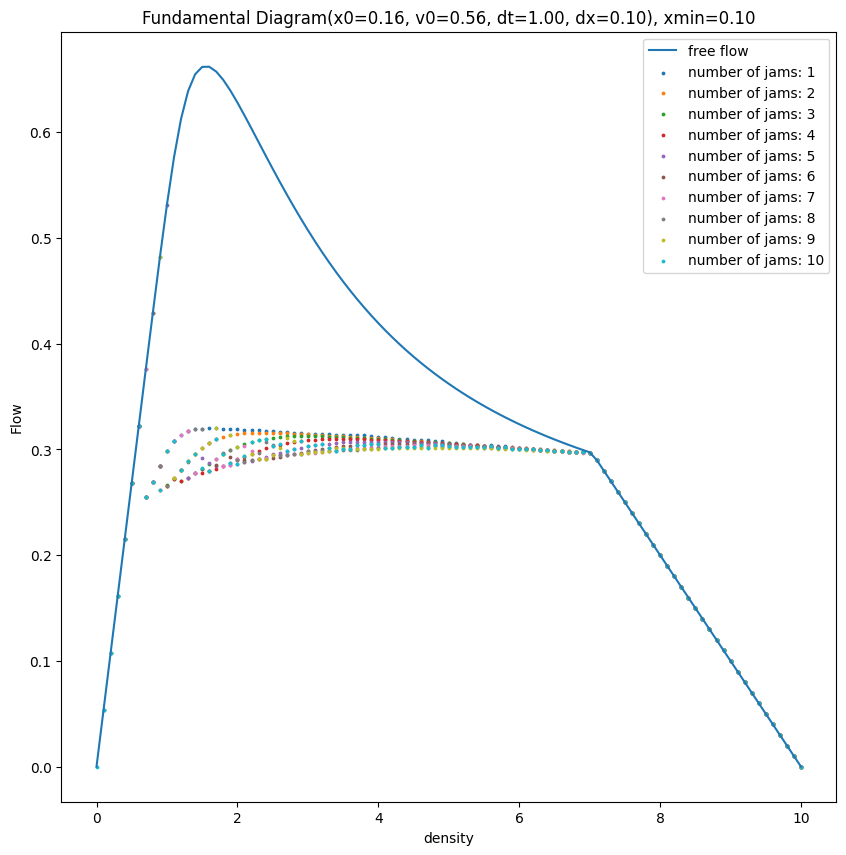

In [6]:
plt.figure(figsize=(10, 10))
plt.xlabel("density")
plt.ylabel("Flow")
plt.title(
	"Fundamental Diagram"
	+ "(x0={:.2f}, v0={:.2f}, dt={:.2f}, dx={:.2f}), xmin={:.2f}"
		.format(x_0, v_0, dt, dx, x_min)
)
plt.plot(density_trivial, flow_trivial, label="free flow")
for jams, data_ in enumerate(data):
	density = [js["density"] for js in data_.values()]
	flow = [js["flow"]["{ni} {nf}"] for js in data_.values()]
	plt.scatter(density, flow, s=3, label="number of jams: {}".format(jams+1))
plt.legend()
plt.show()